# Connect colab to your google drive

In [1]:
# Connect to your google drive
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/School/02_ESE_615/Lab 8

/content/drive/My Drive/School/02_ESE_615/Lab 8


In [3]:
#!unzip f110_dataset_20220209.zip

# Useful tools:

In [4]:
import torch
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn

def DisplayImage(img):
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    # image = np.transpose(image.copy(), (1, 2, 0))
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()

def DisplayLabel(img, bboxs):
    # image = np.transpose(image.copy(), (1, 2, 0))
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    edgecolor = [1, 0, 0]
    if len(bboxs) == 1:
        bbox = bboxs[0]
        ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    elif len(bboxs) > 1:
        for bbox in bboxs:
            ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    ax.imshow(image)
    plt.show()


# Load data:

In [5]:
dataset_folder = 'f110_dataset_20220209/'
path = dataset_folder + "labels.npy" 
labels = np.load(path)
print(len(labels))

1792


In [6]:
final_dim = [5, 10]
input_dim = [180, 320]
anchor_size = [(input_dim[0] / final_dim[0]), (input_dim[1] / final_dim[1])]
arr = np.arange(labels.shape[0])
np.random.shuffle(arr)

# convert feature map coord to image coord
def grid_cell(cell_indx, cell_indy):
    stride_0 = anchor_size[1]
    stride_1 = anchor_size[0]
    return np.array([cell_indx * stride_0, cell_indy * stride_1, cell_indx * stride_0 + stride_0, cell_indy * stride_1 + stride_1])

# convert from [c_x, c_y, w, h] to [x_l, y_l, x_r, y_r]
def bbox_convert(c_x, c_y, w, h):
    return [c_x - w/2, c_y - h/2, c_x + w/2, c_y + h/2]

# convert from [x_l, y_l, x_r, x_r] to [c_x, c_y, w, h]
def bbox_convert_r(x_l, y_l, x_r, y_r):
    return [x_l/2 + x_r/2, y_l/2 + y_r/2, x_r - x_l, y_r - y_l]

# calculating IoU
def IoU(a, b):
    # referring to IoU algorithm in slides
    inter_w = max(0, min(a[2], b[2]) - max(a[0], b[0]))
    inter_h = max(0, min(a[3], b[3]) - max(a[1], b[1]))
    inter_ab = inter_w * inter_h
    area_a = (a[3] - a[1]) * (a[2] - a[0])
    area_b = (b[3] - b[1]) * (b[2] - b[0])
    union_ab = area_a + area_b - inter_ab
    return inter_ab / union_ab

def assign_label(label):
    label_gt = np.zeros((5, final_dim[0], final_dim[1]))
    IoU_threshold = 0.01
    IoU_max = 0
    IoU_max_ind = [0, 0]

    for ind_row in range(final_dim[0]):
        for ind_col in range(final_dim[1]):
            label_assign = 0
            grid_info = grid_cell(ind_col, ind_row)
            label_bbox = bbox_convert(label[0], label[1], label[2], label[3])
            IoU_value = IoU(label_bbox, grid_info)
            if IoU_value > IoU_threshold:
                label_assign = 1
            if IoU_value > IoU_max:
                IoU_max = IoU_value
                IoU_max_ind[0] = ind_row
                IoU_max_ind[1] = ind_col

            # construct the gt vector
            if label_assign == 1:
                label_gt[0, ind_row, ind_col] = 1
                label_gt[1, ind_row, ind_col] = label[0] - (grid_info[0] + anchor_size[1]/2)
                label_gt[2, ind_row, ind_col] = label[1] - (grid_info[1] + anchor_size[0]/2)
                label_gt[3, ind_row, ind_col] = label[2] / float(input_dim[1])
                label_gt[4, ind_row, ind_col] = label[3] / float(input_dim[0])
    
    grid_info = grid_cell(IoU_max_ind[0], IoU_max_ind[1])
    label_gt[0, IoU_max_ind[0], IoU_max_ind[1]] = 1
    label_gt[1, IoU_max_ind[0], IoU_max_ind[1]] = label[0] - (grid_info[0] + anchor_size[1]/2)
    label_gt[2, IoU_max_ind[0], IoU_max_ind[1]] = label[1] - (grid_info[1] + anchor_size[0]/2)
    label_gt[3, IoU_max_ind[0], IoU_max_ind[1]] = label[2] / float(input_dim[1])
    label_gt[4, IoU_max_ind[0], IoU_max_ind[1]] = label[3] / float(input_dim[0])
    return label_gt

# Due to the small size of dataset, we preprocess them into memory to speed up training.
images = []
for ind in range(labels.shape[0]):
    img_path = dataset_folder + str(ind) + '.jpg'
    if (ind%100 == 0):
      print(f"Finished {ind} images")
    img = cv2.imread(img_path) / 255.0
    img = cv2.resize(img, (input_dim[1], input_dim[0]))
    images.append(img)

# Construct datasets
class F110Dataset(torch.utils.data.Dataset):
    def __init__(self, scope, folder, labels):
        self.folder = folder
        self.labels = labels
        self.data_ind1 = (np.floor(self.labels.shape[0] / 10) * scope[0]).astype(int)
        self.data_ind2 = (np.floor(self.labels.shape[0] / 10) * scope[1]).astype(int)

    def __len__(self):
        return self.data_ind2 - self.data_ind1

    def __getitem__(self, index):
        label = self.labels[arr[index]].copy() / (320.0 / input_dim[0])
        label_gt = np.asarray(assign_label(label))
        img_np = images[arr[index]]
        img_np = np.transpose(img_np, (2, 0, 1))
        
        return torch.from_numpy(img_np).type('torch.FloatTensor'), \
                torch.from_numpy(label_gt).type('torch.FloatTensor'), label

train_set = F110Dataset([0, 9.5], dataset_folder, labels)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=1, shuffle=True)
validation_set = F110Dataset([9.5, 10], dataset_folder, labels)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=True)

Finished 0 images
Finished 100 images
Finished 200 images
Finished 300 images
Finished 400 images
Finished 500 images
Finished 600 images
Finished 700 images
Finished 800 images
Finished 900 images
Finished 1000 images
Finished 1100 images
Finished 1200 images
Finished 1300 images
Finished 1400 images
Finished 1500 images
Finished 1600 images
Finished 1700 images


(3, 180, 320)
tensor([235.9688,  96.1875,  87.1875,  60.7500], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[235.9688,  96.1875,  87.1875,  60.7500]], dtype=torch.float64)


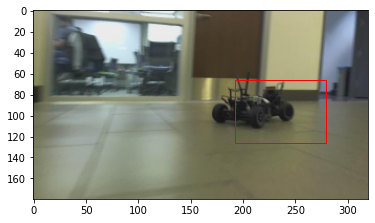

In [7]:
## Plot one label to see if it's correct.

for data_ind, data_list in enumerate(train_loader):
    if data_ind == 0:
        image = data_list[0]
        label_gt = data_list[1]
        label = data_list[2]
        break
print(image[0].numpy().shape)
print(label[0])
print(label_gt[0][0])
print(label)
DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), label)

# Model Definition

In [8]:
class F110_YOLO(torch.nn.Module):
    def __init__(self):
        super(F110_YOLO, self).__init__()
        # TODO: Change the channel depth of each layer
        self.conv1 = nn.Conv2d(3, 4, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm1 = nn.BatchNorm2d(4)
        self.relu1 = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(4, 48, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm2 = nn.BatchNorm2d(48)
        self.relu2 = nn.ReLU(inplace = True)

        self.conv3 = nn.Conv2d(48, 162, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm3 = nn.BatchNorm2d(162)
        self.relu3 = nn.ReLU(inplace = True)
        
        self.conv4 = nn.Conv2d(162, 256, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace = True)

        self.conv5 = nn.Conv2d(256, 512, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU(inplace = True)

        self.conv6 = nn.Conv2d(512,256, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU(inplace = True)

        self.conv7 = nn.ConvTranspose2d(256, 64, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm7 = nn.BatchNorm2d(64)
        self.relu7 = nn.ReLU(inplace = True)

        self.conv8 = nn.ConvTranspose2d(64, 6, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm8 = nn.BatchNorm2d(6)
        self.relu8 = nn.ReLU(inplace = True)

        self.conv9 = nn.Conv2d(6, 5, kernel_size = 1, padding = 0, stride = 1)
        self.relu9 = nn.ReLU()
    
    def forward(self, x):
        debug = 0 # change this to 1 if you want to check network dimensions
        if debug == 1: print(0, x.shape)
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        if debug == 1: print(1, x.shape)
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        if debug == 1: print(2, x.shape)
        x = torch.relu(self.batchnorm3(self.conv3(x)))
        if debug == 1: print(3, x.shape)
        x = torch.relu(self.batchnorm4(self.conv4(x)))
        if debug == 1: print(4, x.shape)
        x = torch.relu(self.batchnorm5(self.conv5(x)))
        if debug == 1: print(5, x.shape)
        x = torch.relu(self.batchnorm6(self.conv6(x)))
        if debug == 1: print(6, x.shape)
        x = torch.relu(self.batchnorm7(self.conv7(x)))
        if debug == 1: print(7, x.shape)
        x = torch.relu(self.batchnorm8(self.conv8(x)))
        if debug == 1: print(8, x.shape)
        x = self.conv9(x)
        if debug == 1: print(9, x.shape)
        x = torch.cat([x[:, 0:3, :, :], torch.sigmoid(x[:, 3:5, :, :])], dim=1)

        return x

    def get_loss(self, result, truth, lambda_coord = 5, lambda_noobj = 1):
        x_loss = (result[:, 1, :, :] - truth[:, 1, :, :]) ** 2
        y_loss = (result[:, 2, :, :] - truth[:, 2, :, :]) ** 2
        w_loss = (torch.sqrt(result[:, 3, :, :]) - torch.sqrt(truth[:, 3, :, :])) ** 2
        h_loss = (torch.sqrt(result[:, 4, :, :]) - torch.sqrt(truth[:, 4, :, :])) ** 2
        class_loss_obj = truth[:, 0, :, :] * (truth[:, 0, :, :] - result[:, 0, :, :]) ** 2
        class_loss_noobj = (1 - truth[:, 0, :, :]) * lambda_noobj * (truth[:, 0, :, :] - result[:, 0, :, :]) ** 2

        total_loss = torch.sum(lambda_coord * truth[:, 0, :, :] * (x_loss + y_loss + w_loss + h_loss) + class_loss_obj + class_loss_noobj)
        
        return total_loss


# Train your network

Save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

In [22]:
## Begin training the model
train_loss_record = []
validation_loss_record = []
device = torch.device('cuda')
model = F110_YOLO().to(device)

In [23]:
## Training Process
batch_size = 10 # TODO: What batchsize is good? 1? 10? 100?
epochs = 1000 # TODO: How many times should we train? 1? 10? 100?
lr = .0005 # TODO: What learning rate is good? 1? 0.1? 0.01?

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.to(device)
    model.train()
    train_loss = []
    validation_loss = []
    # ind = 0

    time_train = 0
    for image_t, label_t, _ in train_loader:     
        image_t = image_t.to(device)
        label_t = label_t.to(device)
        optimizer.zero_grad()
        
        result = model(image_t)
        loss = model.get_loss(result, label_t)
        
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()/batch_size)        
    train_loss_record.append(np.average(train_loss))

    ## validationing
    model.eval()
    object_in_class = 0
    truth_in_class = 0
    for image_t, label_t, _ in validation_loader:
        image_t = image_t.to(device)
        label_t = label_t.to(device)
        result = model(image_t)
        loss = model.get_loss(result, label_t)
        validation_loss.append(loss.item())

    validation_loss_record.append(np.average(validation_loss))
    print("total epoch:", len(train_loss_record), '| train_loss:', np.average(train_loss), '| validation_loss:', np.average(validation_loss), )

# save the model
model_save_name = 'model_{}.pt'.format(len(train_loss_record))
path = "" + model_save_name
torch.save(model.state_dict(), path)

from tempfile import TemporaryFile
path = "loss_{}.npy".format(len(train_loss_record))
outfile = TemporaryFile()
np.save(path, [np.array(train_loss_record), np.array(validation_loss_record)])

total epoch: 1 | train_loss: 311134.01875 | validation_loss: 304605.8893012153
total epoch: 2 | train_loss: 303859.37375 | validation_loss: 299522.27823350695
total epoch: 3 | train_loss: 295089.94279411767 | validation_loss: 290270.2891927083
total epoch: 4 | train_loss: 284081.4107352941 | validation_loss: 280447.9762044271
total epoch: 5 | train_loss: 271573.9069117647 | validation_loss: 262795.2198784722
total epoch: 6 | train_loss: 258168.47529411764 | validation_loss: 248195.39596354167
total epoch: 7 | train_loss: 243753.9379411765 | validation_loss: 228215.55008680557
total epoch: 8 | train_loss: 228935.51014705884 | validation_loss: 211321.00353732638
total epoch: 9 | train_loss: 213253.0643382353 | validation_loss: 192350.5880425347
total epoch: 10 | train_loss: 196443.44908088236 | validation_loss: 176973.54262152777
total epoch: 11 | train_loss: 178589.69641544117 | validation_loss: 160783.6170355903
total epoch: 12 | train_loss: 159731.1765625 | validation_loss: 145643.254

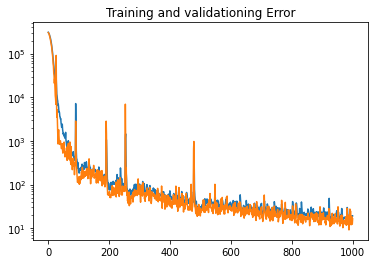

[16.41171958181593]
[19.075269052842085]


In [24]:
## Plot loss curves

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(train_loss_record)), train_loss_record, range(len(validation_loss_record)), validation_loss_record)
ax.set_yscale('log')
ax.set_title('Training and validationing Error')
plt.show()
print(validation_loss_record[-1:])
print(train_loss_record[-1:])

In [25]:
## Converting label to bounding boxes

def label_to_box_xyxy(result, threshold = 0.9):
    validation_result = []
    result_prob = []
    for ind_row in range(final_dim[0]):
        for ind_col in range(final_dim[1]):
            grid_info = grid_cell(ind_col, ind_row)
            validation_result_cell = []
            if result[0, ind_row, ind_col] >= threshold:
                c_x = grid_info[0] + anchor_size[1]/2 + result[1, ind_row, ind_col]
                c_y = grid_info[1] + anchor_size[0]/2 + result[2, ind_row, ind_col]
                w = result[3, ind_row, ind_col] * input_dim[1]
                h = result[4, ind_row, ind_col] * input_dim[0]
                x1, y1, x2, y2 = bbox_convert(c_x, c_y, w, h)
                x1 = np.clip(x1, 0, input_dim[1])
                x2 = np.clip(x2, 0, input_dim[1])
                y1 = np.clip(y1, 0, input_dim[0])
                y2 = np.clip(y2, 0, input_dim[0])
                validation_result_cell.append(x1)
                validation_result_cell.append(y1)
                validation_result_cell.append(x2)
                validation_result_cell.append(y2)
                result_prob.append(result[0, ind_row, ind_col])
                validation_result.append(validation_result_cell)
    validation_result = np.array(validation_result)
    result_prob = np.array(result_prob)
    return validation_result, result_prob


def voting_suppression(result_box, iou_threshold = 0.5):
    votes = np.zeros(result_box.shape[0])
    for ind, box in enumerate(result_box):
        for box_validation in result_box:
            if IoU(box_validation, box) > iou_threshold:
                votes[ind] += 1
    return (-votes).argsort()


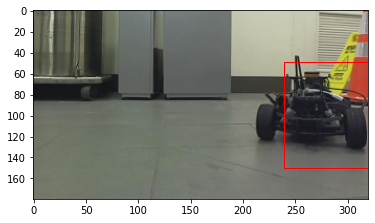

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


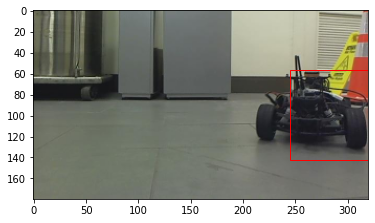

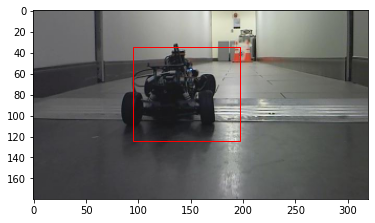

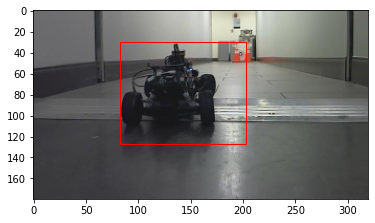

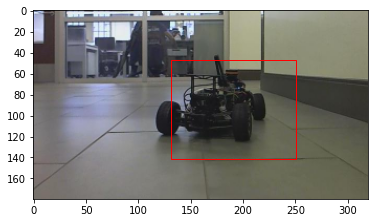

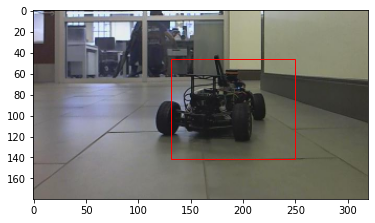

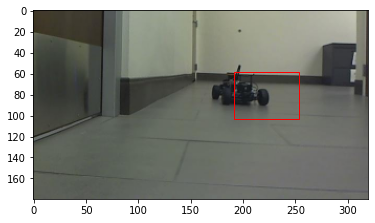

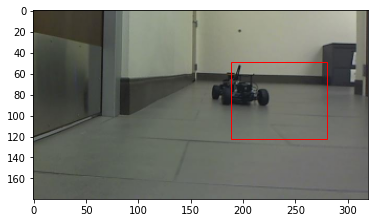

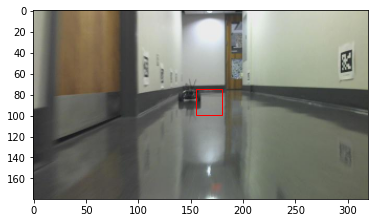

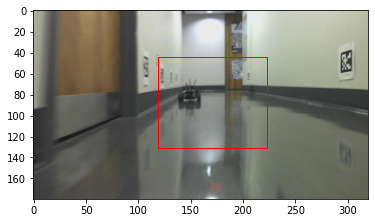

In [26]:
## Display some images in the validation set

# validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=False)
for data_ind, data_list in enumerate(validation_loader):
    image = data_list[0]
    label_gt = data_list[1]
    label = data_list[2]
    if data_ind == 5:
        break
    
    # display groud truth
    DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), label)

    # display detection
    voting_iou_threshold = 0.5
    confi_threshold = 0.4

    image_t = image.to(device)
    label_gt_t = label_gt.to(device)
    result = model(image_t)
    result = result.detach().cpu().numpy()
    bboxs, result_prob = label_to_box_xyxy(result[0], confi_threshold)
    vote_rank = voting_suppression(bboxs, voting_iou_threshold)
    bbox = bboxs[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, w, h]])
    DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), bboxs_2)


In [27]:
## Calculate accuracy

model.eval()
object_in_class = 0
truth_in_class = 0
voting_iou_threshold = 0.5
confi_threshold = 0.5

for data_ind, data_list in enumerate(validation_loader):
    # print(data_ind)

    image = data_list[0]
    label_gt = data_list[1]
    label = data_list[2]

    result = model(image.to(device))
    result = result.detach().cpu().numpy()
    bboxs, result_prob = label_to_box_xyxy(result[0], confi_threshold)
    vote_rank = voting_suppression(bboxs, voting_iou_threshold)
    bbox = bboxs[vote_rank[0]]
    # prob = result_prob[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, w, h]])

    pos_change = np.sqrt((label[0][0] - c_x) ** 2 + (label[0][1] - c_y) ** 2)
    x_l, y_l, x_r, y_r = bbox_convert(label[0][0], label[0][1], label[0][2], label[0][3])
    label_xxyy = [x_l, y_l, x_r, y_r]
    # print(label[0])
    # print(bboxs_2[0])
    # print(pos_change)
    if pos_change < 20 and IoU(bbox, label_xxyy) > 0.5:
        object_in_class += 1
    truth_in_class += 1

accuracy = object_in_class / truth_in_class

print('accuracy', accuracy)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


accuracy 0.6222222222222222


In [32]:
## load the model
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = F110_YOLO()
model_save_name = 'model_1000.pt'
path = F"/content/drive/My Drive/School/02_ESE_615/Lab 8/{model_save_name}"
model.load_state_dict(torch.load(path))
model = model.to(device)

path = F"/content/drive/My Drive/School/02_ESE_615/Lab 8/loss_1000.npy" 
loss = np.load(path, allow_pickle=True)